In [252]:
import requests
import datetime
import json
from pprint import pprint

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import seaborn as sns

import os
import pandas as pd
import numpy as np
import geopandas as gpd
import contextily as cx

In [253]:
CMR_OPS = 'https://cmr.earthdata.nasa.gov/search'  # Root CMR search endpoint

In [254]:
# For a list of granules, extract the colection time for each
def get_times(granules, times_df):
    for granule in granules:
        gran_list = [granule['producer_granule_id'],
                    granule['time_start'][:-5].replace('T', ' '),
                    granule['day_night_flag']]
        
        times_df.loc[len(times_df)] = gran_list

    times_df['time_start'] = pd.to_datetime(times_df['time_start'], format='%Y-%m-%d %H:%M:%S')
    times_df['date'] = [dt.date() for dt in times_df['time_start']]
    times_df['time'] = [dt.time() for dt in times_df['time_start']]
    return(times_df)

# Search collections by project name - used to find collection_id 
def get_collections(project_name):
    url = f'{CMR_OPS}/{"collections"}'

    params = {
        #'cloud_hosted' : 'True',
        #'has_granules' : 'True',
        #'provider' : provider,
        'project' : project_name,
        'page_size' : 2000
    }

    headers = {
        'Accept' : 'application/json'
    }

    response = requests.get(url,
                            params=params,
                            headers=headers
                            )

    collections = response.json()['feed']['entry']
    for collection in collections:
        #print(f'{collection["archive_center"]} | {collection["dataset_id"]} | {collection["short_name"]} |{collection["id"]}')
        print(f'{collection["short_name"]} |{collection["id"]}')

# Return all granules give a point coordinate, date range, and specified collection
def get_granules(lat, lon, collection_id, date_range):
    url = f'{CMR_OPS}/{"granules"}'
    point_str = str(lon) + ',' + str(lat)

    params = {
        'concept_id' : collection_id,
        'temporal' : date_range,
        'point' : point_str,
        'page_size' : 500
    }

    headers = {
        'Accept' : 'application/json'
    }

    response = requests.get(url,
                            params=params,
                            headers=headers
                            )
    if(response.status_code == 200):
        hits = response.headers['CMR-Hits']
        print(f'Hits: {hits}')

        granules = response.json()['feed']['entry']
        #for granule in granules:
            #print(f'{granule["data_center"]} | {granule["title"]} | {granule["id"]} | {granule["time_start"]}')
    
        return granules, hits
    else:
        print(f"Response Code: {response.status_code}")
        print(point_str, collection_id, date_range)

In [255]:
get_collections('AQUA')

AIRXAMAP |C1233769004-GES_DISC
AIRABRAD |C1243477366-GES_DISC
AIRXBCAL |C1243477315-GES_DISC
AIRHBRAD |C1243477367-GES_DISC
AIRIBRAD |C1243477369-GES_DISC
AIRIBQAP |C1243477368-GES_DISC
AIRABRAD_NRT |C1233769000-GES_DISC
AIRIBRAD_NRT_BUFR |C1233769001-GES_DISC
AIRIBRAD_NRT |C1233768982-GES_DISC
AIRIBQAP_NRT |C1233768981-GES_DISC
AIRVBRAD_NRT |C1233768984-GES_DISC
AIRVBQAP_NRT |C1233768983-GES_DISC
AIRVBRAD |C1243477373-GES_DISC
AIRVBQAP |C1243477372-GES_DISC
AIRICRAD |C1675477037-GES_DISC
AIRICRAD_NRT |C1712047294-GES_DISC
AIRI2CCF |C1243477378-GES_DISC
AIRH2CCF |C1243477316-GES_DISC
AIRS2CCF |C1243477380-GES_DISC
AIRX2STC |C1243477314-GES_DISC
AIRS2STC |C1243477371-GES_DISC
AIRX2SPC |C1243477374-GES_DISC
AIRS2SPC |C1243477370-GES_DISC
AIRS2CCF_NRT |C1345119267-GES_DISC
AIRS2RET_NRT |C1345119345-GES_DISC
AIRS2SUP_NRT |C1345119372-GES_DISC
AIRX2RET |C1243477383-GES_DISC
AIRH2RET |C1243477376-GES_DISC
AIRS2RET |C1243477381-GES_DISC
AIRX2SUP |C1243477317-GES_DISC
AIRH2SUP |C1243477377-GES

In [256]:
# Construct point df
point_coords = {'latitude':[34.003463], 'longitude':[-119.858675]}  # SCI POZO SM02
point_df = pd.DataFrame(data=point_coords)
point_df

,latitude,longitude
0,34.003463,-119.858675


In [257]:
# Search granules
terra_collection_id = 'C1378227407-LAADS' # MOD021KM
aqua_collection_id = 'C1379758607-LAADS' # MYD021KM

date_range = '2023-01-01T00:00:00Z,2023-12-31T23:59:59Z'


## Get Terra collects
terra_times_df = pd.DataFrame(columns=['granule_id', 'time_start', 'day_night_flag'])
terra_full_granule_list = []
terra_hit_counts_list = []

### Get granules for all records in point_df
for index, point in point_df.iterrows():
    lat = point['latitude']
    lon = point['longitude']
    granules, hits = get_granules(lat, lon, terra_collection_id, date_range)
    [terra_full_granule_list.append(granule) for granule in granules]  # Unpack the returned list and add each item to full list
    terra_hit_counts_list.append(hits)

terra_times_df = get_times(terra_full_granule_list, terra_times_df)
#point_df['HitCount'] = terra_hit_counts_list


## Get Aqua Collects
aqua_times_df = pd.DataFrame(columns=['granule_id', 'time_start', 'day_night_flag'])
aqua_full_granule_list = []
aqua_hit_counts_list = []

### Get granules for all records in point_df
for index, point in point_df.iterrows():
    lat = point['latitude']
    lon = point['longitude']
    granules, hits = get_granules(lat, lon, aqua_collection_id, date_range)
    [aqua_full_granule_list.append(granule) for granule in granules]  # Unpack the returned list and add each item to full list
    aqua_hit_counts_list.append(hits)

aqua_times_df = get_times(aqua_full_granule_list, aqua_times_df)

Hits: 785
Hits: 790


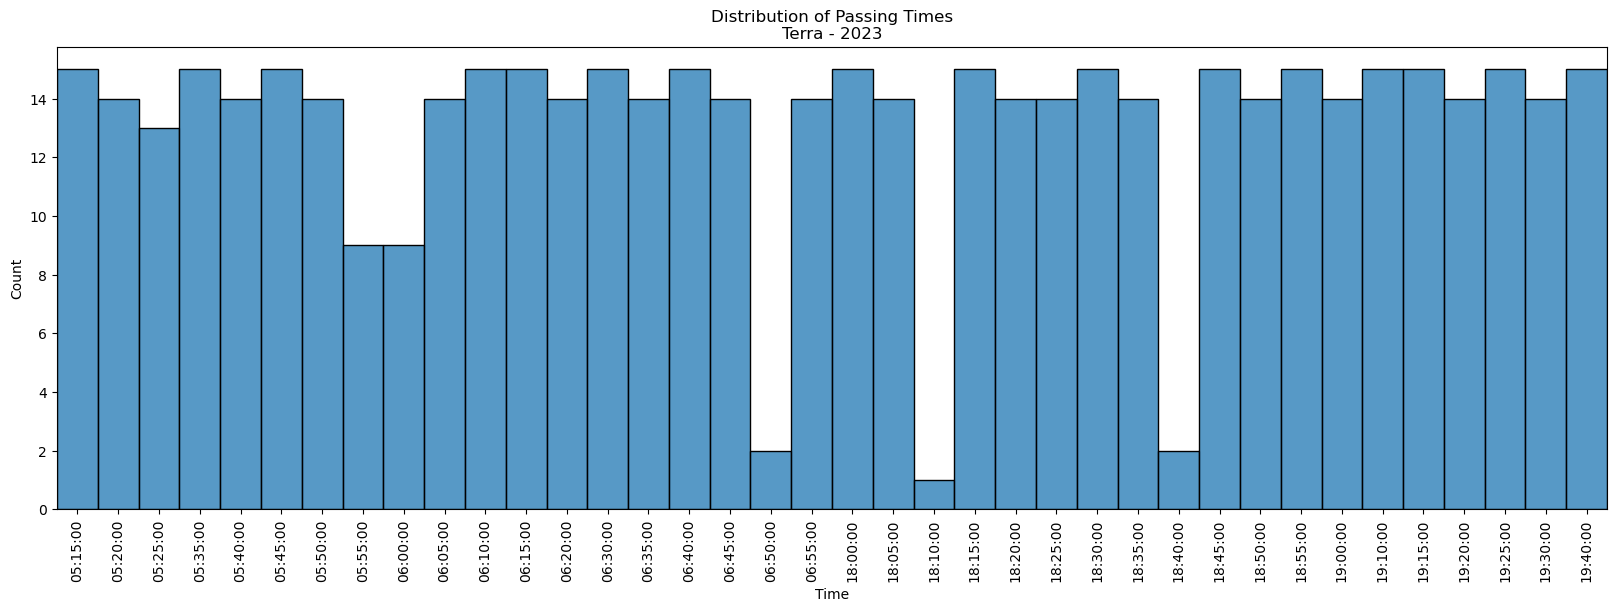

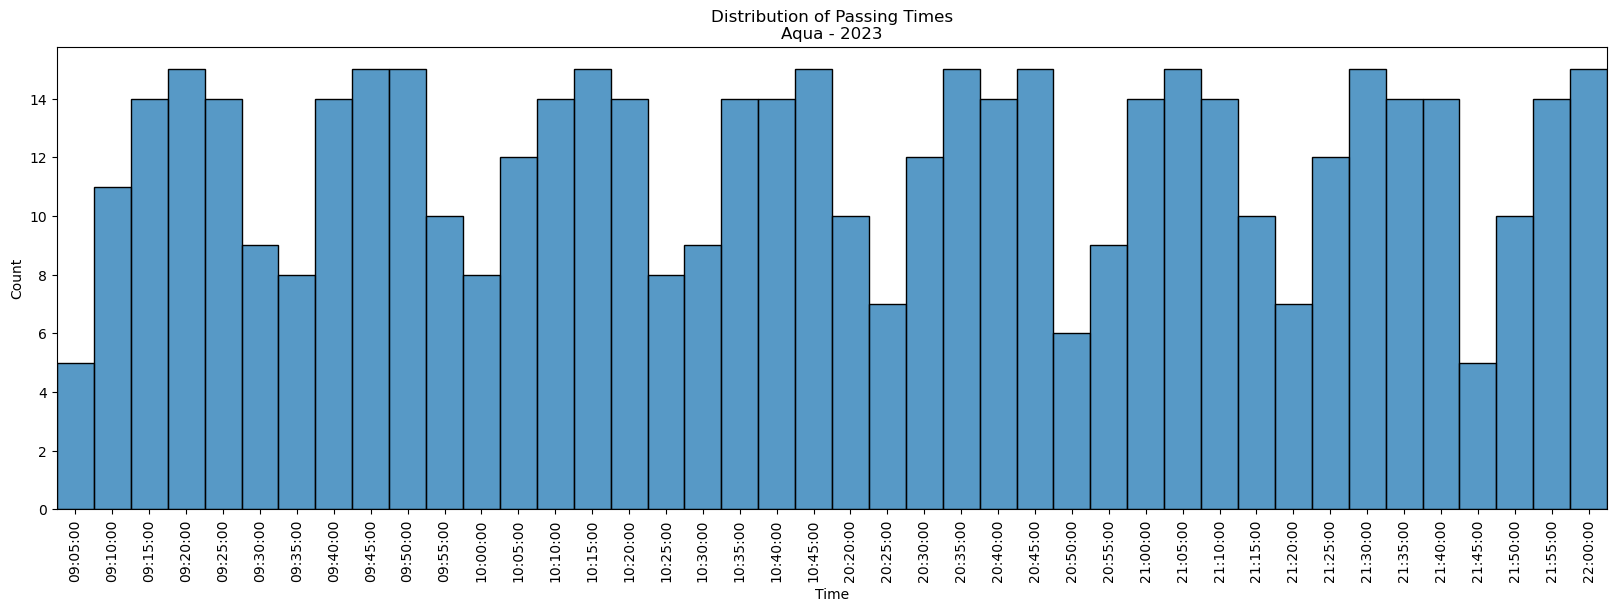

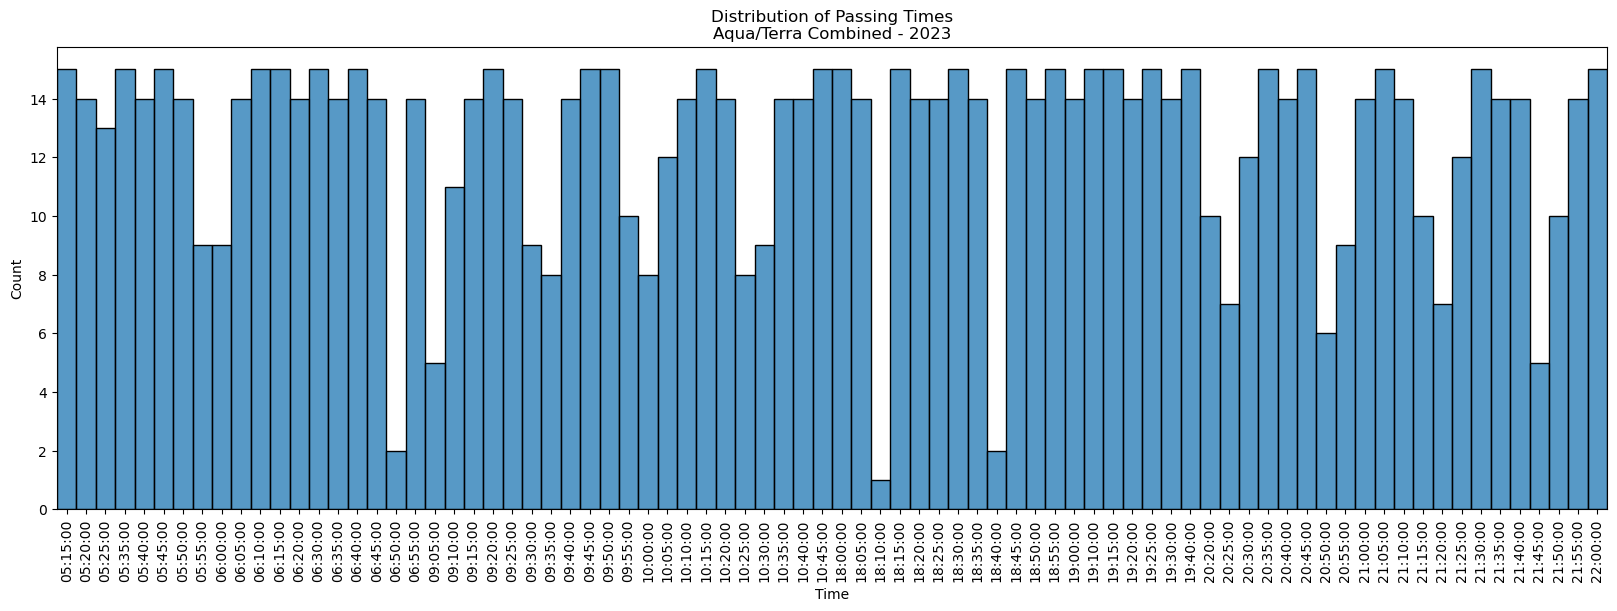

In [258]:
# Create time of day histograms
figsize = (20,6)


## Reformat data
terra_times_list = terra_times_df['time'].copy().sort_values(ascending=True)
terra_str_list = [str(x) for x in terra_times_list]

aqua_times_list = aqua_times_df['time'].copy().sort_values(ascending=True)
aqua_str_list = [str(x) for x in aqua_times_list]

comb_times_list = pd.concat([terra_times_list, aqua_times_list])
comb_times_list.sort_values(ascending=True, inplace=True)
comb_str_list = [str(x) for x in comb_times_list]

## Create Terra Histogram
fig, ax = plt.subplots(figsize=figsize)

sns.histplot(terra_str_list)

ax.set(title='Distribution of Passing Times\nTerra - 2023',
       xlabel='Time')
plt.margins(x=0)
plt.xticks(rotation=90)
plt.show()

## Create Aqua Histogram
fig, ax = plt.subplots(figsize=figsize)

sns.histplot(aqua_str_list)

ax.set(title='Distribution of Passing Times\nAqua - 2023',
       xlabel='Time')
plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()

## Create Combined Histogram
fig, ax = plt.subplots(figsize=figsize)

sns.histplot(comb_str_list)

ax.set(title='Distribution of Passing Times\nAqua/Terra Combined - 2023',
       xlabel='Time')


plt.margins(x=0)
plt.xticks(rotation=90)
plt.show()

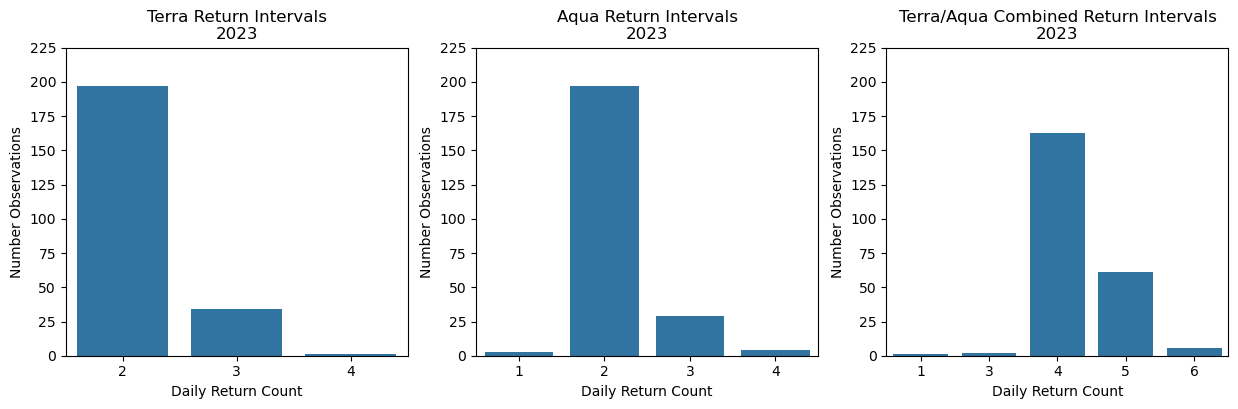

In [259]:
# Get return intervals

## Group terra data
terra_gp = terra_times_df.groupby('date').count().reset_index().iloc[:,0:2]
terra_gp.columns = ['date', 'count']
terra_gp = terra_gp.groupby('count').count().reset_index()
terra_gp.columns = ['daily_return', 'count']
terra_gp

## Group aqua data
aqua_gp = aqua_times_df.groupby('date').count().reset_index().iloc[:,0:2]
aqua_gp.columns = ['date', 'count']
aqua_gp = aqua_gp.groupby('count').count().reset_index()
aqua_gp.columns = ['daily_return', 'count']
aqua_gp

## Group combined data
combined_times_df = pd.concat([terra_times_df, aqua_times_df])

combined_gp = combined_times_df.groupby('date').count().reset_index().iloc[:,0:2]
combined_gp.columns = ['date', 'count']
combined_gp = combined_gp.groupby('count').count().reset_index()
combined_gp.columns = ['daily_return', 'count']
combined_gp

## Plot Return Intervals
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.barplot(data=aqua_gp,
            x='daily_return',
            y='count',
            ax=ax[0])
sns.barplot(data=terra_gp,
            x='daily_return',
            y='count',
            ax=ax[1])
sns.barplot(data=combined_gp,
            x='daily_return',
            y='count',
            ax=ax[2])

ax[0].set(title='Terra Return Intervals\n2023',
          xlabel='Daily Return Count',
          ylabel='Number Observations')
ax[0].set_ylim(0, 225)

ax[1].set(title='Aqua Return Intervals\n2023',
          xlabel='Daily Return Count',
          ylabel='Number Observations')
ax[1].set_ylim(0, 225)

ax[2].set(title='Terra/Aqua Combined Return Intervals\n2023',
          xlabel='Daily Return Count',
          ylabel='Number Observations')
ax[2].set_ylim(0, 225)


plt.show()


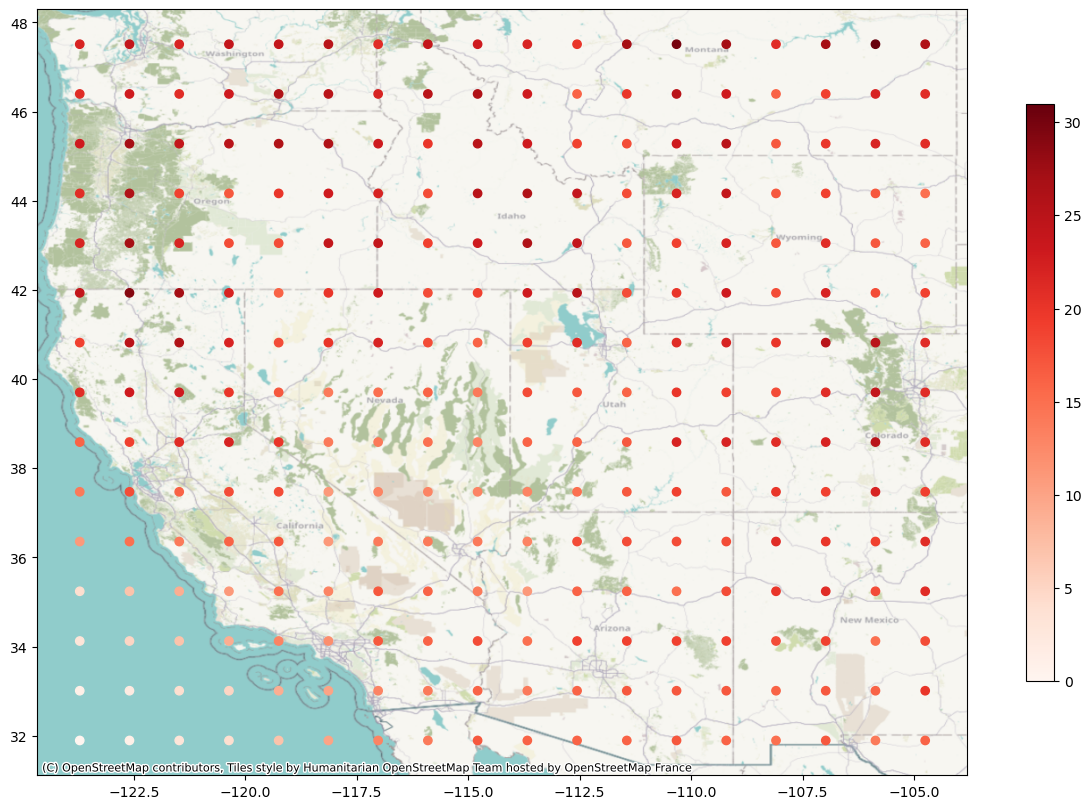

In [30]:

# !! NOTE: This is legacy code from a previous project (ECOSTRESS)

# Map the hit counts
#inci_gdf = gpd.GeoDataFrame(inci_df, geometry=gpd.points_from_xy(inci_df.InitialLongitude, inci_df.InitialLatitude), crs='EPSG:4326')

#ax = inci_gdf.plot(column=inci_gdf['HitCount'].astype('int'), cmap='Reds', figsize=(15,15), legend=True, legend_kwds={'shrink':0.5})
#cx.add_basemap(ax, crs=inci_gdf.crs)

# Map the hit counts
point_gdf = gpd.GeoDataFrame(point_df, geometry=gpd.points_from_xy(point_df.longitude, point_df.latitude), crs='EPSG:4326')

ax = point_gdf.plot(column=point_gdf['HitCount'].astype('int'), cmap='Reds', figsize=(15,15), legend=True, legend_kwds={'shrink':0.5})
cx.add_basemap(ax, crs=point_gdf.crs)